# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design T cells that respond to diseases like cancer.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import least_squares

np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    assert L0.shape == v.shape
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    ## Solve Req by calling least_squares
    lsq = least_squares(diffFunAnon, np.full_like(L0, Rtot/2.0), jac_sparsity=np.eye(L0.size),
                        max_nfev=1000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        bounds=(np.full_like(L0, -np.finfo(float).eps), np.full_like(L0, Rtot)))
    #if lsq['cost'] > 1.0E-8:
       # print(lsq)
        #raise RuntimeError("Failure in solving for Req.")
        
    Req = lsq.x
    Lbound = np.zeros(Req.size)
    Rmulti = np.zeros(Req.size)
    Rbnd = np.zeros(Req.size)
    
    for ii, Reqq in enumerate(Req):
        # Calculate vieq from equation 1
        vieq = L0[ii]*Reqq*binom(v[ii], np.arange(1, v[ii] + 1))*np.power(Kx*Reqq, np.arange(v[ii]))/Kd

        # Calculate L, according to equation 7
        Lbound[ii] = np.sum(vieq)

        # Calculate Rmulti from equation 5
        Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=float))

        # Calculate Rbound
        Rbnd[ii] = Rmulti[ii] + vieq[0]

    return (Lbound, Rbnd, Rmulti)

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

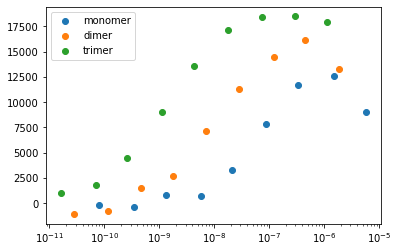

In [52]:

plt.xscale('log')


plt.scatter(Xs[0:9],Ys[0:9],label = 'dimer')
plt.scatter(Xs[9:18],Ys[9:18],label = 'trimer')
plt.scatter(Xs[18:],Ys[18:],label = 'tetramer')
plt.legend()


#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

Text(0, 0.5, 'CD3')

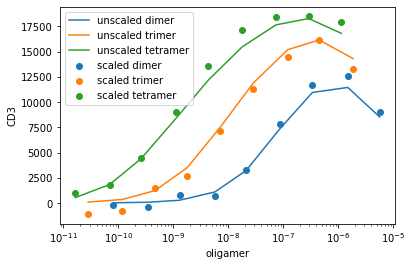

In [5]:
scale = 1 
Kd27 = 1.70e-6
Kx27 = 3.15e-4
Rtot27 = 24000
v27 = np.repeat([2,3,4],9)



def Yscalefunction(scale,Rtot,Kd,v,Kx,L0):
    Rmulti27 = np.zeros(len(L0))
    Rbnd27 = np.zeros(len(L0))
    Lbound27 = np.zeros(len(L0))
    Lbound27,Rbnd27,Rmulti27 = StoneMod(Rtot,Kd,v,Kx,L0)
    Rmulti27 = Rmulti27*scale
    return Rmulti27

newY = Yscalefunction(scale,Rtot27,Kd27,v27,Kx27,Xs)

plt.xscale('log')
plt.plot(Xs[0:9],newY[0:9],label = 'unscaled dimer')
plt.plot(Xs[9:18],newY[9:18],label = 'unscaled trimer')
plt.plot(Xs[18:],newY[18:],label = 'unscaled tetramer')
plt.scatter(Xs[0:9],Ys[0:9],label = 'scaled dimer')
plt.scatter(Xs[9:18],Ys[9:18],label = 'scaled trimer')
plt.scatter(Xs[18:],Ys[18:],label = 'scaled tetramer')
plt.legend()
plt.xlabel('oligamer')
plt.ylabel('CD3')

#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [7]:
Kd27 = 1.7e-6
Kx27 = 3.15e-4
Rtot27 = 24000
scale = 1.0
v27 = np.repeat([2,3,4],9)
def scaledYs(Rtot27,Kd27,Kx27,Xs,scale,v27):
    Lbound = np.zeros(len(Xs))
    Rbound = np.zeros(len(Xs))
    Rmulti = np.zeros(len(Xs))
    Lbound,Rbound,Rmulti = StoneMod(Rtot27,Kd27,v27,Kx27,Xs)
    return Rmulti*scale 

param = [Kd27,Kx27,scale]
def findresiduals(param,Xs,Ys,v27,Rtot27): 
    print(param)
    return(Ys-scaledYs(Rtot27,param[0],param[1],Xs,param[2],v27))

def leastsquares(Kd27,Kx27,scale,Xs,Ys,v27,Rtot27): 
    initial = [Kd27,Kx27,scale]
    res = least_squares(findresiduals,initial,args=[Xs,Ys,v27,Rtot27])
    return res.x

residuals = leastsquares(Kd27,Kx27,scale,Xs,Ys,v27,Rtot27)
print(residuals)



[1.70e-06 3.15e-04 1.00e+00]
[1.71490116e-06 3.15000000e-04 1.00000000e+00]
[1.70000000e-06 3.15014901e-04 1.00000000e+00]
[1.70000000e-06 3.15000000e-04 1.00000001e+00]
[1.70288801e-06 3.14684777e-04 1.02819028e+00]
[1.71778917e-06 3.14684777e-04 1.02819028e+00]
[1.70288801e-06 3.14699678e-04 1.02819028e+00]
[1.70288801e-06 3.14684777e-04 1.02819029e+00]
[1.70286024e-06 3.14734021e-04 1.02814719e+00]
[1.71776140e-06 3.14734021e-04 1.02814719e+00]
[1.70286024e-06 3.14748922e-04 1.02814719e+00]
[1.70286024e-06 3.14734021e-04 1.02814721e+00]
[1.70286055e-06 3.14731350e-04 1.02815016e+00]
[1.71776172e-06 3.14731350e-04 1.02815016e+00]
[1.70286055e-06 3.14746251e-04 1.02815016e+00]
[1.70286055e-06 3.14731350e-04 1.02815018e+00]
[1.70286055e-06 3.14731350e-04 1.02815016e+00]


#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

Text(0, 0.5, 'CD3')

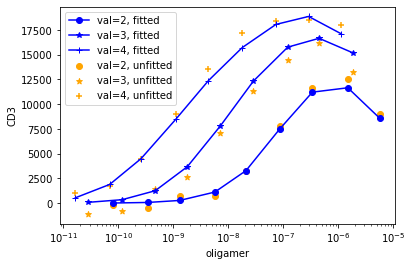

In [107]:
#within each fold of crossvalidation we want to build our model from scratch over again. 
#for each fold of crossvalidation he found the parameters from least squares 
#from there, 
def lstsquares(parameters,Rtot,Xs,Ys,v):
    answer = least_squares(findresiduals,parameters,args=[Rtot,Xs,Ys,v])
    return answer

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
x = np.linspace(0,27,27)
cv_Y = np.zeros(27)
for train_index, test_index in loo.split(Xs):
    X_train, X_test= Xs[train_index], Xs[test_index]
    Y_train, Y_test= Ys[train_index], Ys[test_index]
    V_train, V_test= Vs[train_index], Vs[test_index]
    
    fitted_parameters = leastsquares(Kd27,Kx27,scale,X_train,Y_train,V_train,Rtot27)
    
    cv_Y[test_index] = Yscalefunction(fitted_parameters[2],Rtot27, fitted_parameters[0],V_test,fitted_parameters[1],X_test)

plt.xscale('log')
plt.plot(Xs[0:9],cv_Y[0:9],label = 'val=2, fitted',color = 'blue',marker='o')
plt.plot(Xs[9:18],cv_Y[9:18],label = 'val=3, fitted', color = 'blue',marker = '*')
plt.plot(Xs[18:],cv_Y[18:],label = 'val=4, fitted', color = 'blue',marker = '+')
plt.scatter(Xs[0:9],Ys[0:9],label = 'val=2, unfitted', color = 'orange',marker = 'o')
plt.scatter(Xs[9:18],Ys[9:18],label = 'val=3, unfitted', color = 'orange',marker = '*')
plt.scatter(Xs[18:],Ys[18:],label = 'val=4, unfitted', color = 'orange',marker = '+')
plt.legend() 
plt.xlabel('oligamer') 
plt.ylabel('CD3')
    


#### (5) Using bootstrap estimation, plot the confidence interval of the model predictions along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

In [78]:
scale = 1 
Kd27 = 1.70e-6
Kx27 = 3.15e-4
Rtot27 = 24000
v27 = np.repeat([2,3,4],9)
parameters = [Kd27,Kx27,scale]
bs_array = np.zeros((100,27))
from sklearn.utils import resample
for i in range(100): 
    bootstrapped_Xs, bootstrapped_Ys = resample(Xs,Ys)
    lst = lstsquares(parameters,Rtot27,bootstrapped_Xs,bootstrapped_Ys,v27)
    fittedparameters = lst.x
    bsYs = Yscalefunction(fittedparameters[2],Rtot27, fittedparameters[0],v27,fittedparameters[1],Xs)
    bs_array[i,:] = bsYs 


{'whiskers': [<matplotlib.lines.Line2D at 0xa4de1c0>,
 'caps': [<matplotlib.lines.Line2D at 0xa4de520>,
 'boxes': [<matplotlib.lines.Line2D at 0xa4d4fe8>,
 'medians': [<matplotlib.lines.Line2D at 0xa4de880>,
 'fliers': [<matplotlib.lines.Line2D at 0xa4dea30>,
 'means': []}

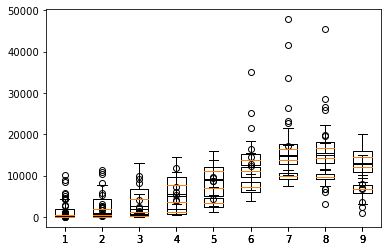

In [108]:
def scalemulti(Rtot27,Kd27,Kx27,Xs,scale,v27): 
    Lbound = np.zeros(len(Xs))
    Rbound = np.zeros(len(Xs))
    Rmulti = np.zeros(len(Xs))
    
    Lbound,Rbound,Rmulti = StoneMod(Rtot27,Kd27,v27,Kx27,Xs)
    return Rmulti*scale 

bsmulti = np.zeros((100,27))
for i in range(100): 
    bootstrapped_Xs, bootstrapped_Ys = resample(Xs,Ys)
    fittedparameters = leastsquares(Kd27,Kx27,scale,bootstrapped_Xs,bootstrapped_Ys,v27,Rtot27)
    bsmulti[i] = scalemulti(Rtot27,fittedparameters[0],fittedparameters[1],Xs,fittedparameters[2],v27)
    
dimerfitted5 = bsmulti[:,0:9]
trimerfitted6 = bsmulti[:,9:18]
tetramerfitted7 = bsmulti[:,18:]
plt.boxplot(dimerfitted5)
plt.boxplot(trimerfitted6)
plt.boxplot(tetramerfitted7)

Text(0.5, 1.0, 'Predicted Rmulti with Bootstrap, Valency = 2')

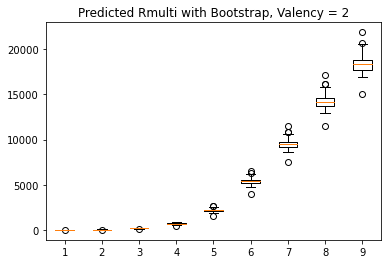

In [109]:
plt.boxplot(dimerfitted)
plt.title('Predicted Rmulti with Bootstrap, Valency = 2')

Text(0.5, 1.0, 'Predicted Rmulti with Bootstrap, Valency = 3')

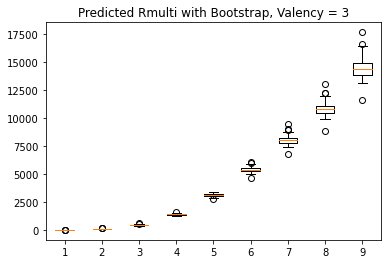

In [110]:
plt.boxplot(trimerfitted)
plt.title('Predicted Rmulti with Bootstrap, Valency = 3')

{'whiskers': [<matplotlib.lines.Line2D at 0xc795778>,
 'caps': [<matplotlib.lines.Line2D at 0xc7b1e50>,
 'boxes': [<matplotlib.lines.Line2D at 0xc7b9c28>,
 'medians': [<matplotlib.lines.Line2D at 0xc7cbaa8>,
 'fliers': [<matplotlib.lines.Line2D at 0xc7cbbe0>,
 'means': []}

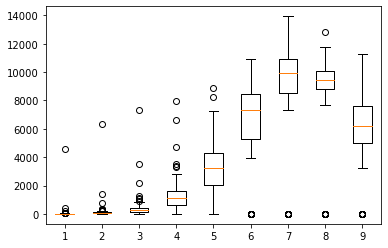

In [171]:
plt.boxplot(tetramerfitted)
plt.title('Predicted Rmulti with Bootstrap, Valency = 4')

####(6) How would you expect the cross-validation and bootstrap results to change if you had fewer data points?

I would expect my cross-validation and bootstrap results to be less accurate with fewer data points, since we would be able to do one less fold for the cross-validation, and for the bootstrap there would be more of the same values repeated in each sample. 

#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

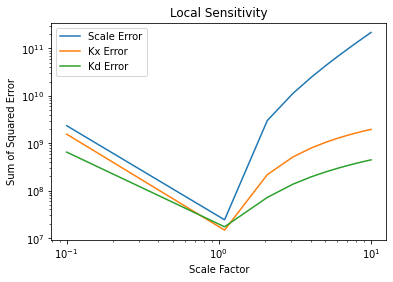

In [211]:
#The parameter that influences the fit the most is the scale, and the parameter that influences the fit the least is Kd. 
#This is because scale has the largest sum of squared error, and Kd has the smallest sum of squared error. 

scale = 1 
Kd27 = 1.70e-6
Kx27 = 3.15e-4
Rtot27 = 24000
v27 = np.repeat([2,3,4],9)
vary = np.linspace(.1,10,11)
l = len(vary)
scale_e = np.zeros(l)
Kx_e = np.zeros(l)
Kd_e = np.zeros(l)
parameters = [Kd27,Kx27,scale]

for i in range(l): 
    scale_e[i]= np.sum(StoneModresiduals([Kd27,Kx27,scale*vary[i]],Rtot27,Xs,Ys,v27)**2)
    Kx_e[i]= np.sum(StoneModresiduals([Kd27,Kx27*vary[i],scale],Rtot27,Xs,Ys,v27)**2)
    Kd_e[i]= np.sum(StoneModresiduals([Kd27*vary[i],Kx27,scale],Rtot27,Xs,Ys,v27)**2)

plt.plot(vary,scale_e, label = "Scale Error")
plt.plot(vary,Kx_e,label = "Kx Error")
plt.plot(vary,Kd_e, label = "Kd Error")
plt.xscale('log')
plt.yscale('log')
plt.title("Local Sensitivity")
plt.xlabel("Scale Factor")
plt.ylabel("Sum of Squared Error")
plt.legend()

#### (8) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

My parameter values will be more specified with a global analysis, since the other parameters can adjust to compensate for outlandish values of the varying parameter. 

#### (9) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when $K_d$ increases?

Hint: The easiest way to do this is mess with the bounds of the least squares solver.

In [ ]:
#Yes, my prediction was true as the sum of squared error is decreased for all three parameters. When Kd increases, the other parameters likely decrease to compensate for the increase in Kd. 

In [86]:
Kd27 = 1.7e-6
Kx27 = 3.15e-4
Rtot27 = 24000
scale = 1.0
v27 = np.repeat([2,3,4],9)
def scaledYs(Rtot27,Kd27,Kx27,Xs,scale,v27):
    Lbound = np.zeros(len(Xs))
    Rbound = np.zeros(len(Xs))
    Rmulti = np.zeros(len(Xs))
    Lbound,Rbound,Rmulti = StoneMod(Rtot27,Kd27,v27,Kx27,Xs)
    return Rmulti*scale 

param = [Kd27,Kx27,scale]
def findresiduals(param,Xs,Ys,v27,Rtot27): 
    return(Ys-scaling(Rtot27,param[0],param[1],Xs,param[2],v27))

def leastsquares(Kd27,Kx27,scale,Xs,Ys,v27,Rtot27): 
    initial = [Kd27,Kx27,scale]
    res = least_squares(findresiduals,initial,args=[Xs,Ys,v27,Rtot27])
    return res.x


residuals = leastSquares(Kd27,Kx27,scale,Xs,Ys,v27,Rtot27)
print(residuals)

[1.70286055e-06 3.14731350e-04 1.02815016e+00]


In [74]:
scaleglobal = np.zeros(len(vary))
Kxglobal = np.zeros(len(vary))
Kdglobal = np.zeros(len(vary))

scale = 1 
Kd27 = 1.7e-6
Kx27 = 3.15e-4
Rtot27 = 24000
v27 = np.repeat([2,3,4],9)
vary = np.linspace(.1,10,10)
print(vary)
lower = 0.8
upper = 1.2 


for i in range(len(vary)): 
    scaleinitial = [Kd27,Kx27,scale*vary[i]]
    scalenew = least_squares(findresiduals,scaleinitial,args =(Xs,Ys,v27,Rtot27),bounds = ([-np.inf*Kd27,-np.inf*Kx27,lower*scale*vary[i]],[np.inf*Kd27,np.inf*Kx27,scale*vary[i]*upper]))
    scalenew = scalenew.x
    scaleglobal[i] = sum(findresiduals(scalenew,Xs,Ys,v27,Rtot27)**2)
    
    Kxinitial = [Kd27,Kx27*vary[i],scale]
    Kxnew =least_squares(findresiduals,Kxinitial,args =(Xs,Ys,v27,Rtot27),bounds = ([-np.inf*Kd27,Kx27*vary[i]*lower,-np.inf*scale],[np.inf*Kd27,upper*vary[i]*Kx27,scale*np.inf]))
    Kxnew = Kxnew.x
    Kxglobal[i] = sum(findresiduals(Kxnew,Xs,Ys,v27,Rtot27)**2)
    
    Kdinitial = [Kd27*vary[i],Kx27,scale]
    Kdnew = least_squares(findresiduals,Kdinitial,args =(Xs,Ys,v27,Rtot27),bounds = ([Kd27*lower*vary[i],-np.inf*Kx27,-np.inf*scale],[upper*vary[i]*Kd27,np.inf*Kx27,scale*np.inf]))
    Kdnew = Kdnew.x
    Kdglobal[i] = sum(findresiduals(Kdnew,Xs,Ys,v27,Rtot27)**2)
    

[ 0.1  1.2  2.3  3.4  4.5  5.6  6.7  7.8  8.9 10. ]


Text(0, 0.5, 'Sum of Squared Factor')

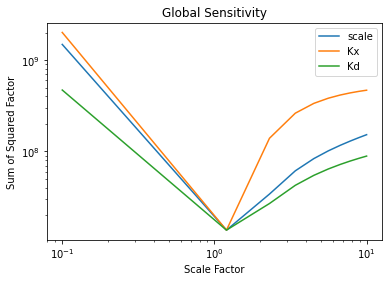

In [75]:
plt.plot(vary,Kxglobal,label = 'scale')
plt.plot(vary,scaleglobal,label = 'Kx')
plt.plot(vary,Kdglobal,label = 'Kd')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Global Sensitivity')
plt.xlabel('Scale Factor')
plt.ylabel('Sum of Squared Factor')

#### (10) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters.

In [98]:
def scaleligand(Rtot27,Kd27,Kx27,Xs,scale,v27): 
    Lbound = np.zeros(len(Xs))
    Rbound = np.zeros(len(Xs))
    Rmulti = np.zeros(len(Xs))
    
    Lbound,Rbound,Rmulti = StoneMod(Rtot27,Kd27,v27,Kx27,Xs)
    return Lbound*scale 
bsligand = np.zeros((100,27))
for i in range(100): 
    bootstrapped_Xs, bootstrapped_Ys,bootstrapped_Vs = resample(Xs,Ys,v27)
    fittedparameters = leastsquares(Kd27,Kx27,scale,bootstrapped_Xs,bootstrapped_Ys,bootstrapped_Vs,Rtot27)
    bsligand[i] = scaleligand(Rtot27,fittedparameters[0],fittedparameters[1],Xs,fittedparameters[2],v27)
    
dimerfitted = bsligand[:,0:9]
trimerfitted = bsligand[:,9:18]
tetramerfitted =bsligand[:,18:]
    
def scalerbound(Rtot27,Kd27,Kx27,Xs,scale,v27): 
    Lbound = np.zeros(len(Xs))
    Rbound = np.zeros(len(Xs))
    Rmulti = np.zeros(len(Xs))
    
    Lbound,Rbound,Rmulti = StoneMod(Rtot27,Kd27,v27,Kx27,Xs)
    return Rbound*scale 
bsbound = np.zeros((100,27))
for i in range(100): 
    bootstrapped_Xs, bootstrapped_Ys, bootstrapped_Vs = resample(Xs,Ys,v27)
    fittedparameters = leastsquares(Kd27,Kx27,scale,bootstrapped_Xs,bootstrapped_Ys,bootstrapped_Vs,Rtot27)
    bsbound[i] = scalerbound(Rtot27,fittedparameters[0],fittedparameters[1],Xs,fittedparameters[2],v27)
    
dimerfitted1 = bsbound[:,0:9]
trimerfitted2 = bsbound[:,9:18]
tetramerfitted3 =bsbound[:,18:]

Text(0.5, 1.0, 'Predicted Ligands with Bootstrap, Valency = 2')

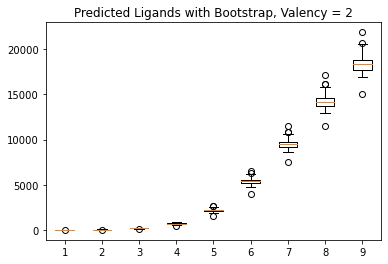

In [99]:
plt.boxplot(dimerfitted)
plt.title('Predicted Ligands with Bootstrap, Valency = 2')

Text(0.5, 1.0, 'Predicted Ligands with Bootstrap, Valency = 3')

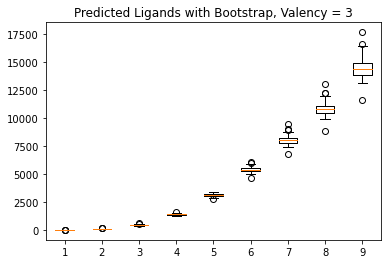

In [100]:
plt.boxplot(trimerfitted)
plt.title('Predicted Ligands with Bootstrap, Valency = 3')

Text(0.5, 1.0, 'Predicted Ligands with Bootstrap, Valency = 4')

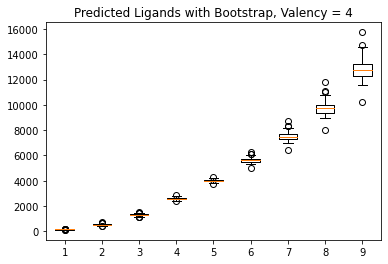

In [101]:
plt.boxplot(tetramerfitted)
plt.title('Predicted Ligands with Bootstrap, Valency = 4')

Text(0.5, 1.0, 'Predicted Rbound with Bootstrap, Valency = 2')

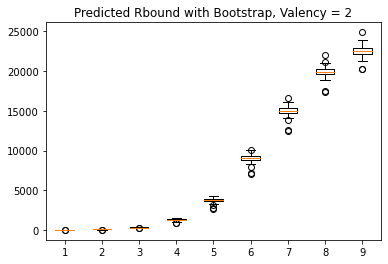

In [102]:
plt.boxplot(dimerfitted1)
plt.title('Predicted Rbound with Bootstrap, Valency = 2')

Text(0.5, 1.0, 'Predicted Rbound with Bootstrap, Valency = 3')

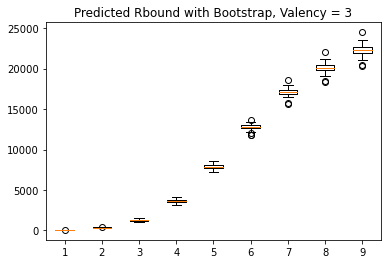

In [103]:
plt.boxplot(trimerfitted2)
plt.title('Predicted Rbound with Bootstrap, Valency = 3')

Text(0.5, 1.0, 'Predicted Rbound with Bootstrap, Valency = 4')

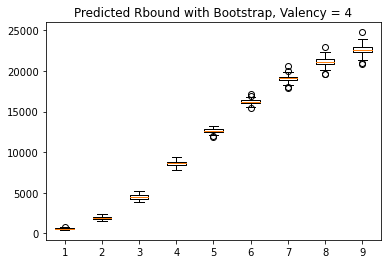

In [104]:
plt.boxplot(tetramerfitted3)
plt.title('Predicted Rbound with Bootstrap, Valency = 4')